In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [26]:
# Load the labeled index data from csv
labeled_index_df = pd.read_csv("./data/index/labeled_index.csv")

## Period Adjustment
- To predict a crash on day t, the daily price changes from each day prior to t could be used as a feature

In [91]:
# TODO
month = 3

## Build the model

In [145]:
# Set up the training and testing sets
X = labeled_index_df[['price_change', 'volume', 'volatility']]
y = labeled_index_df['crash_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [147]:
# Resampling
smote = SMOTE(sampling_strategy='auto')
under_sampler = RandomUnderSampler(sampling_strategy='auto')

X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = under_sampler.fit_resample(X_train_res, y_train_res)

In [148]:
# Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'sag', 'saga']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

In [149]:
# Train the model
model = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
model.fit(X_train, y_train)

LogisticRegression(C=0.1, solver='liblinear')

## Model Evaluation 
- Precision: number of True Positives / (number of True Positives + number of False Positives)
- Recall: number of True Positives / (number of True Positives + number of False Negatives)
- F1 score: A weighted average of precision and recall, F1 = 2*((precision*recall)/(precision+recall))

In [150]:
# Evaluate the model
y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.00698856416772554
Confusion Matrix:
[[   0 6252]
 [   0   44]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6252
           1       0.01      1.00      0.01        44

    accuracy                           0.01      6296
   macro avg       0.00      0.50      0.01      6296
weighted avg       0.00      0.01      0.00      6296



Problem: low recall and f1 score for crash label 1

## K-fold Validation

In [119]:
# Perform 10-fold cross-validation
scores = cross_val_score(model, x, y, cv=10)

# Print the cross-validation scores
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.99237611 0.99237611 0.99237611 0.99237611 0.99237611 0.99237611
 0.99237611 0.99237611 0.99237611 0.99205845]
Average cross-validation score: 0.99


## Prediction Result

In [155]:
y_prob = model.predict_proba(X_test)
crash_prob = y_prob[:, 1]
print(f"Crash Probability: {crash_prob.mean()}")

Crash Probability: 0.08957909783989837


## AUC-ROC

AUC-ROC Score: 0.6944814023148955


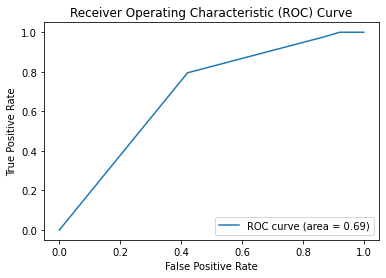

In [161]:
auc_roc = roc_auc_score(y_test, y_prob[:, 1])

print("AUC-ROC Score:", auc_roc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, -1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()